# CAE-LSTM Hybrid Model (Training)

**Authors:** KHOO Jing Heng, Zayne SIEW

**Version:** 1.0 (05/04/2025)

### About this notebook

This notebook implements a CAE-LSTM model for training on the ECoG data.

### Requirements

- Python 3
- Matplotlib
- Numpy
- Scipy
- Torch

## 0. Imports and Torch-CUDA Config

In [ ]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from constants import (
    SUBJECT_ID,
    CHANNELS_NUM,
    ECOG_TRAIN_FILEPATH,
    ECOG_VAL_FILEPATH,
    FLEXION_TRAIN_FILEPATH,
    FLEXION_VAL_FILEPATH,
    WAVELET_NUM,
)
from data import EcogDataset, plot_ecog_data
from eval import cosine_correlation_metric, pearson_correlation_metric, test_model
from model import EncoderDecoder

In [ ]:
# For windows/linux will try CUDA first, then CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# Set default device for following code, so we don't need to specify device every time
torch.set_default_device(DEVICE)

## 1. Data Loading and Visualisation

In [4]:
# Define directory where data is stored
DATA_DIR = "../data"

finger_flex_cropped: np.ndarray = np.load(f'{DATA_DIR}/{FLEXION_TRAIN_FILEPATH}')
X_spectrogram_cropped: np.ndarray = np.load(f'{DATA_DIR}/{ECOG_TRAIN_FILEPATH}')

finger_flex_cropped_val: np.ndarray = np.load(f'{DATA_DIR}/{FLEXION_VAL_FILEPATH}')
X_spectrogram_cropped_val: np.ndarray = np.load(f'{DATA_DIR}/{ECOG_VAL_FILEPATH}')

In [6]:
train_dataset = EcogDataset(X_spectrogram_cropped, finger_flex_cropped)
print(X_spectrogram_cropped.shape, finger_flex_cropped.shape)
print(len(train_dataset))

val_dataset = EcogDataset(X_spectrogram_cropped_val, finger_flex_cropped_val)
print(X_spectrogram_cropped_val.shape, finger_flex_cropped_val.shape)
print(len(val_dataset))

(62, 40, 39980) (5, 39980)
39724
(62, 40, 19980) (5, 19980)
19724


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, generator=torch.Generator(device=DEVICE))
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, generator=torch.Generator(device=DEVICE))

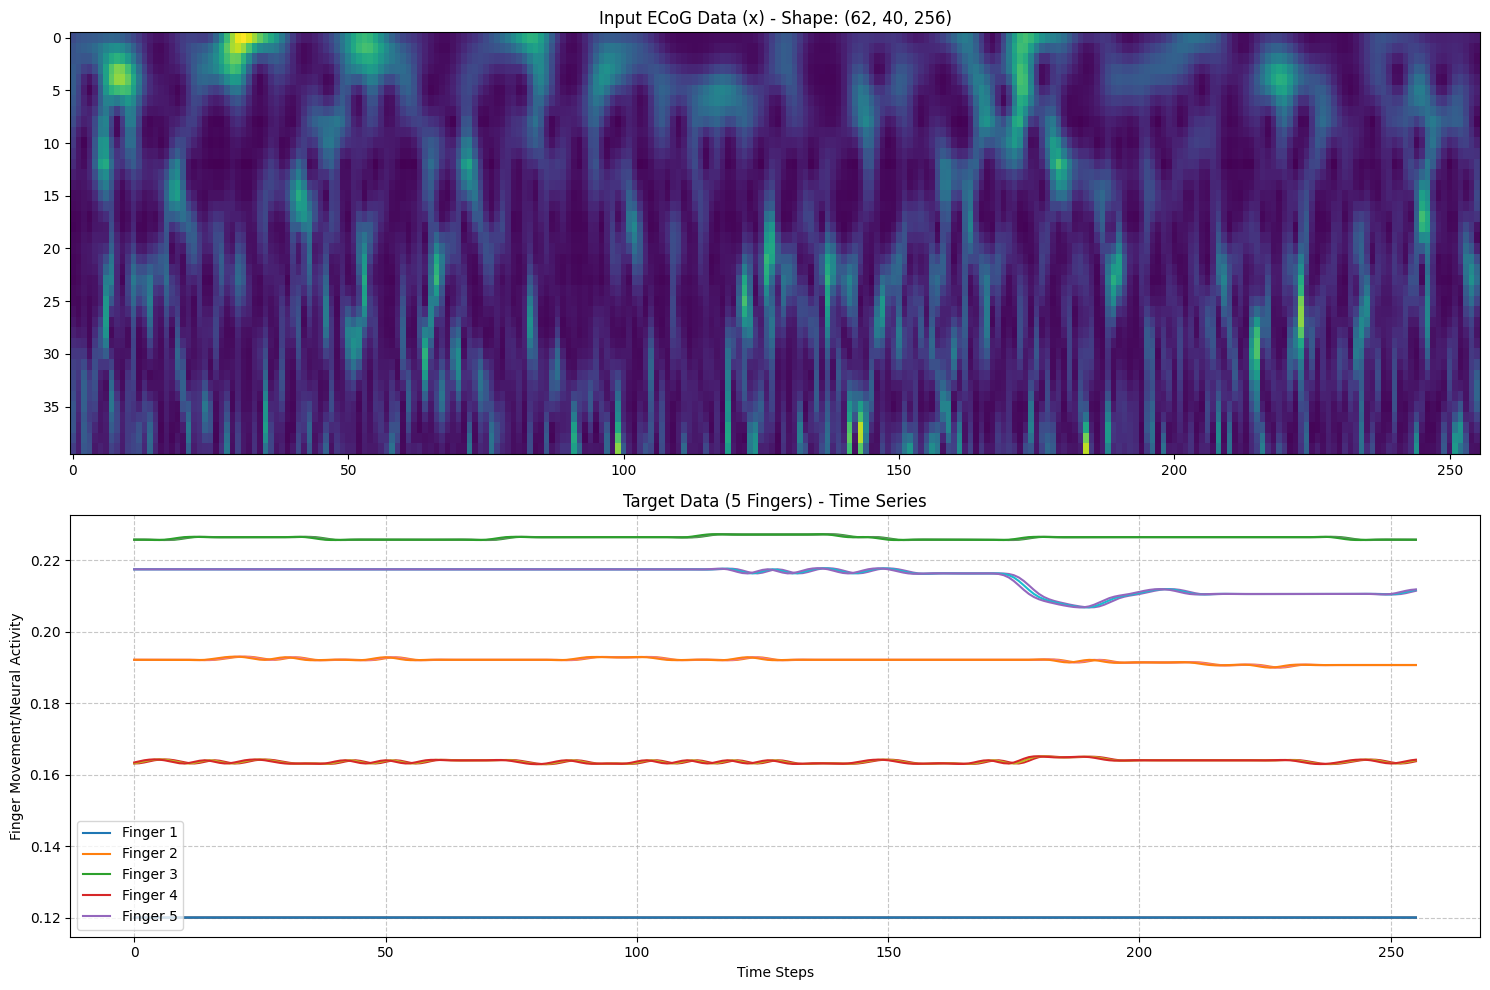

Input (x) Data Statistics:
Shape: (62, 40, 256)
Mean: 36.44956970214844
Std: 112.34618377685547
Min: -78.30249786376953
Max: 2913.20654296875

Target (y) Data Statistics:
Shape: (5, 256)
Mean: 0.18342195451259613
Std: 0.038283176720142365
Min: 0.12006422877311707
Max: 0.22728414833545685


In [ ]:
# Call the visualization function
plot_ecog_data(train_dataset)

## 2. Model Training

This section trains a new `EncoderDecoder` model.

In [ ]:
def train(
    model: EncoderDecoder,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 100,
    lr: float = 1e-3,
    device: torch.device = DEVICE,
    alpha: float = 0.5,
    weight_decay: float = 1e-4,
) -> EncoderDecoder:
    """Trains an instance of an `EncoderDecoder` model.

    This function also outputs evaluation metrics on the validation set while training.

    Parameters:
        model (EncoderDecoder):
            The `EncoderDecoder` model instance to train.
        train_lodaer (DataLoader):
            Dataloader of the training dataset.
        val_loader (DataLoader):
            Dataloader of the validation dataset.
        num_epochs (int, default=100):
            Number of epochs to train the model on.
        lr (float, default=1e-3):
            Learning rate of the `AdamW` optimiser.
        device (torch.device, default=DEVICE):
            Desired torch device to use for computation.
        alpha (float, default=0.5):
            Weightage in loss function between MSE loss and cosine similarity.
        weight_decay (float, default=1e-4):
            Weight decay for the `AdamW` optimiser.

    Returns:
        EncoderDecoder:
            The trained model.
    """

    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, val_losses = [], []
    train_corrs, val_corrs = [], []
    pearson_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_corr = 0.0

        for batch in train_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            pred = model(x)

            mse_loss = F.mse_loss(pred, y)
            corr = cosine_correlation_metric(pred, y)
            final_loss = alpha*mse_loss + alpha*(1. - corr)

            final_loss.backward()
            optimizer.step()

            train_loss += final_loss.item()
            train_corr += corr.item()

        train_loss /= len(train_loader)
        train_corr /= len(train_loader)
        train_losses.append(train_loss)
        train_corrs.append(train_corr)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Corr: {train_corr:.4f}")

        model.eval()
        val_loss = 0.0
        val_corr = 0.0
        pearson_loss_sum = 0.0
        with torch.no_grad():
            for batch in val_loader:
                x, y = batch
                x, y = x.to(device), y.to(device)

                pred = model(x)

                mse_loss = F.mse_loss(pred, y)
                corr = cosine_correlation_metric(pred, y)
                final_loss = alpha*mse_loss + alpha*(1. - corr)

                pearson_loss_metric = pearson_correlation_metric(pred, y)

                val_loss += final_loss.item()
                val_corr += corr.item()
                pearson_loss_sum += pearson_loss_metric.item()

        val_loss /= len(val_loader)
        val_corr /= len(val_loader)
        pearson_loss_sum /= len(val_loader)

        val_losses.append(val_loss)
        val_corrs.append(val_corr)
        pearson_losses.append(pearson_loss_sum)

        print(f"Epoch {epoch+1}/{num_epochs} - Val Loss: {val_loss:.4f}, Val Corr: {val_corr:.4f}, Pearson Corr: {pearson_loss_sum:.4f}")

    # Plot training and validation loss
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    # Plot correlation metrics
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_corrs, label='Train Corr', marker='o')
    plt.plot(range(1, num_epochs + 1), val_corrs, label='Val Corr', marker='o')
    plt.plot(range(1, num_epochs + 1), pearson_losses, label='Pearson Corr', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Correlation")
    plt.legend()
    plt.title("Training, Validation, Pearson Correlation")

    plt.tight_layout()
    plt.show()

    return model

In [ ]:
# model = EncoderDecoder(input_channels=CHANNELS_NUM * WAVELET_NUM, output_channels=5)
# model = train(model, train_loader, val_loader, num_epochs=50)

### 2.1 GridSearchCV Hyperparameter Tuning

We tune on the learning rate, alpha, and weight decay.


Testing hyperparams: {'lr': 0.01, 'alpha': 0.3, 'weight_decay': 0.0001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.0785, Train Corr: 0.8986
Epoch 1/50 - Val Loss: 0.0257, Val Corr: 0.9403, Pearson Corr: 0.2832
Epoch 2/50 - Train Loss: 0.0122, Train Corr: 0.9679
Epoch 2/50 - Val Loss: 0.0229, Val Corr: 0.9453, Pearson Corr: 0.4978
Epoch 3/50 - Train Loss: 0.0062, Train Corr: 0.9833
Epoch 3/50 - Val Loss: 0.0225, Val Corr: 0.9461, Pearson Corr: 0.5286
Epoch 4/50 - Train Loss: 0.0039, Train Corr: 0.9895
Epoch 4/50 - Val Loss: 0.0231, Val Corr: 0.9450, Pearson Corr: 0.4976
Epoch 5/50 - Train Loss: 0.0030, Train Corr: 0.9920
Epoch 5/50 - Val Loss: 0.0238, Val Corr: 0.9425, Pearson Corr: 0.4947
Epoch 6/50 - Train Loss: 0.0026, Train Corr: 0.9933
Epoch 6/50 - Val Loss: 0.0225, Val Corr: 0.9458, Pearson Corr: 0.5231
Epoch 7/50 - Train Loss: 0.0021, Train Corr: 0.9946
Epoch 7/50 - Val Loss: 0.0212, Val Corr: 0.9497, Pearson Corr: 0.5266
Epoch 8/50 - Train Loss: 0.0017, Train Corr: 0.9955
Epo

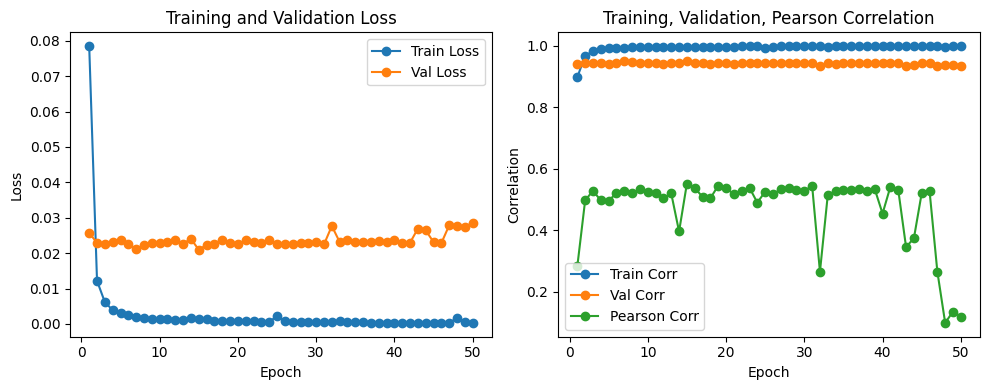

Final Pearson score: 0.1677

Testing hyperparams: {'lr': 0.01, 'alpha': 0.3, 'weight_decay': 0.001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.0558, Train Corr: 0.9114
Epoch 1/50 - Val Loss: 0.0235, Val Corr: 0.9463, Pearson Corr: 0.3477
Epoch 2/50 - Train Loss: 0.0098, Train Corr: 0.9738
Epoch 2/50 - Val Loss: 0.0226, Val Corr: 0.9465, Pearson Corr: 0.4883
Epoch 3/50 - Train Loss: 0.0052, Train Corr: 0.9858
Epoch 3/50 - Val Loss: 0.0222, Val Corr: 0.9484, Pearson Corr: 0.4667
Epoch 4/50 - Train Loss: 0.0035, Train Corr: 0.9905
Epoch 4/50 - Val Loss: 0.0226, Val Corr: 0.9473, Pearson Corr: 0.5042
Epoch 5/50 - Train Loss: 0.0027, Train Corr: 0.9926
Epoch 5/50 - Val Loss: 0.0247, Val Corr: 0.9429, Pearson Corr: 0.3893
Epoch 6/50 - Train Loss: 0.0022, Train Corr: 0.9943
Epoch 6/50 - Val Loss: 0.0222, Val Corr: 0.9466, Pearson Corr: 0.5262
Epoch 7/50 - Train Loss: 0.0017, Train Corr: 0.9955
Epoch 7/50 - Val Loss: 0.0223, Val Corr: 0.9475, Pearson Corr: 0.4773
Epoch 8/50 - Train Loss: 0.0

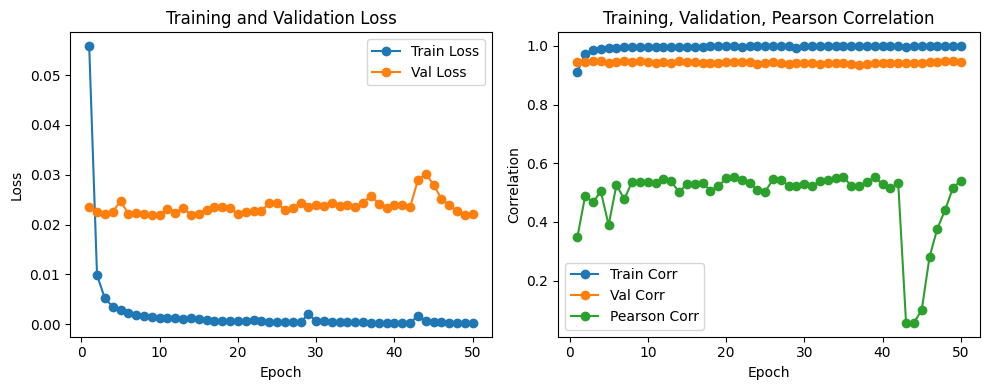

Final Pearson score: 0.5776

Testing hyperparams: {'lr': 0.01, 'alpha': 0.5, 'weight_decay': 0.0001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.0932, Train Corr: 0.9106
Epoch 1/50 - Val Loss: 0.0377, Val Corr: 0.9452, Pearson Corr: 0.5158
Epoch 2/50 - Train Loss: 0.0149, Train Corr: 0.9761
Epoch 2/50 - Val Loss: 0.0404, Val Corr: 0.9419, Pearson Corr: 0.4616
Epoch 3/50 - Train Loss: 0.0072, Train Corr: 0.9882
Epoch 3/50 - Val Loss: 0.0376, Val Corr: 0.9448, Pearson Corr: 0.5546
Epoch 4/50 - Train Loss: 0.0047, Train Corr: 0.9924
Epoch 4/50 - Val Loss: 0.0385, Val Corr: 0.9436, Pearson Corr: 0.5302
Epoch 5/50 - Train Loss: 0.0035, Train Corr: 0.9945
Epoch 5/50 - Val Loss: 0.0375, Val Corr: 0.9450, Pearson Corr: 0.5507
Epoch 6/50 - Train Loss: 0.0029, Train Corr: 0.9954
Epoch 6/50 - Val Loss: 0.0366, Val Corr: 0.9470, Pearson Corr: 0.5394
Epoch 7/50 - Train Loss: 0.0023, Train Corr: 0.9965
Epoch 7/50 - Val Loss: 0.0381, Val Corr: 0.9441, Pearson Corr: 0.5394
Epoch 8/50 - Train Loss: 0.

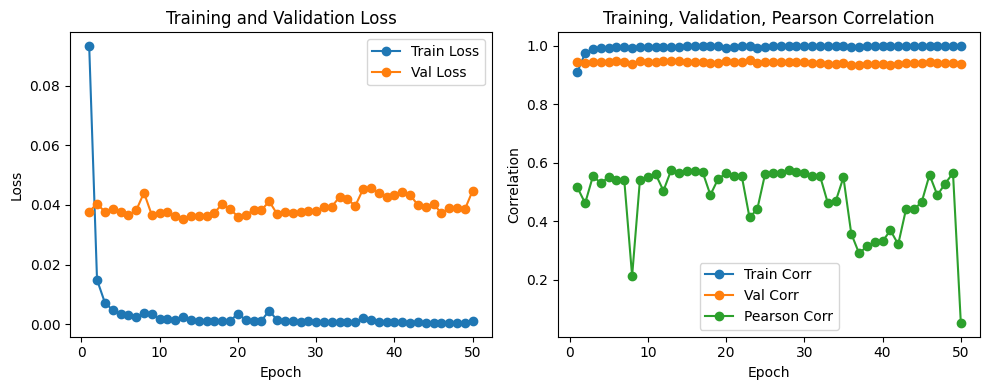

Final Pearson score: 0.0736

Testing hyperparams: {'lr': 0.01, 'alpha': 0.5, 'weight_decay': 0.001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.1340, Train Corr: 0.9025
Epoch 1/50 - Val Loss: 0.0405, Val Corr: 0.9440, Pearson Corr: 0.3054
Epoch 2/50 - Train Loss: 0.0220, Train Corr: 0.9667
Epoch 2/50 - Val Loss: 0.0365, Val Corr: 0.9488, Pearson Corr: 0.4874
Epoch 3/50 - Train Loss: 0.0103, Train Corr: 0.9836
Epoch 3/50 - Val Loss: 0.0385, Val Corr: 0.9437, Pearson Corr: 0.5211
Epoch 4/50 - Train Loss: 0.0072, Train Corr: 0.9884
Epoch 4/50 - Val Loss: 0.0352, Val Corr: 0.9487, Pearson Corr: 0.5443
Epoch 5/50 - Train Loss: 0.0058, Train Corr: 0.9908
Epoch 5/50 - Val Loss: 0.0399, Val Corr: 0.9415, Pearson Corr: 0.4934
Epoch 6/50 - Train Loss: 0.0045, Train Corr: 0.9929
Epoch 6/50 - Val Loss: 0.0410, Val Corr: 0.9392, Pearson Corr: 0.5023
Epoch 7/50 - Train Loss: 0.0038, Train Corr: 0.9941
Epoch 7/50 - Val Loss: 0.0380, Val Corr: 0.9450, Pearson Corr: 0.5117
Epoch 8/50 - Train Loss: 0.0

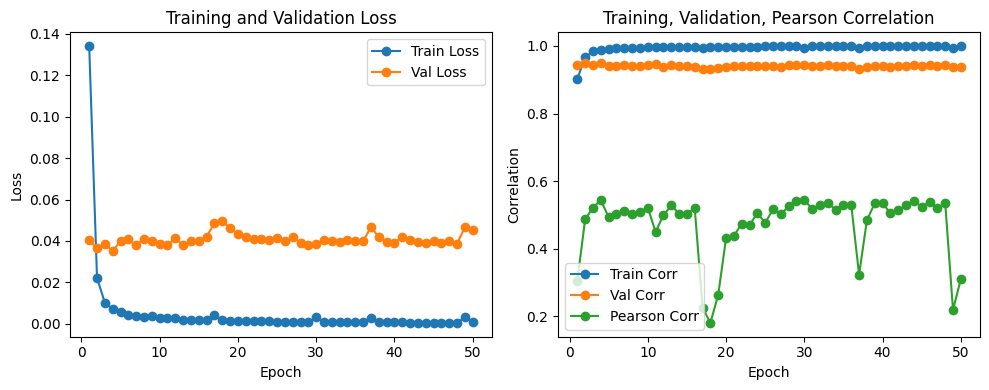

Final Pearson score: 0.3193

Testing hyperparams: {'lr': 0.01, 'alpha': 0.7, 'weight_decay': 0.0001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.1346, Train Corr: 0.9075
Epoch 1/50 - Val Loss: 0.0582, Val Corr: 0.9405, Pearson Corr: 0.3925
Epoch 2/50 - Train Loss: 0.0264, Train Corr: 0.9698
Epoch 2/50 - Val Loss: 0.0598, Val Corr: 0.9375, Pearson Corr: 0.4397
Epoch 3/50 - Train Loss: 0.0112, Train Corr: 0.9870
Epoch 3/50 - Val Loss: 0.0644, Val Corr: 0.9323, Pearson Corr: 0.3840
Epoch 4/50 - Train Loss: 0.0071, Train Corr: 0.9919
Epoch 4/50 - Val Loss: 0.0625, Val Corr: 0.9343, Pearson Corr: 0.4173
Epoch 5/50 - Train Loss: 0.0054, Train Corr: 0.9940
Epoch 5/50 - Val Loss: 0.0597, Val Corr: 0.9391, Pearson Corr: 0.3521
Epoch 6/50 - Train Loss: 0.0067, Train Corr: 0.9925
Epoch 6/50 - Val Loss: 0.0617, Val Corr: 0.9349, Pearson Corr: 0.4577
Epoch 7/50 - Train Loss: 0.0038, Train Corr: 0.9958
Epoch 7/50 - Val Loss: 0.0610, Val Corr: 0.9352, Pearson Corr: 0.4764
Epoch 8/50 - Train Loss: 0.

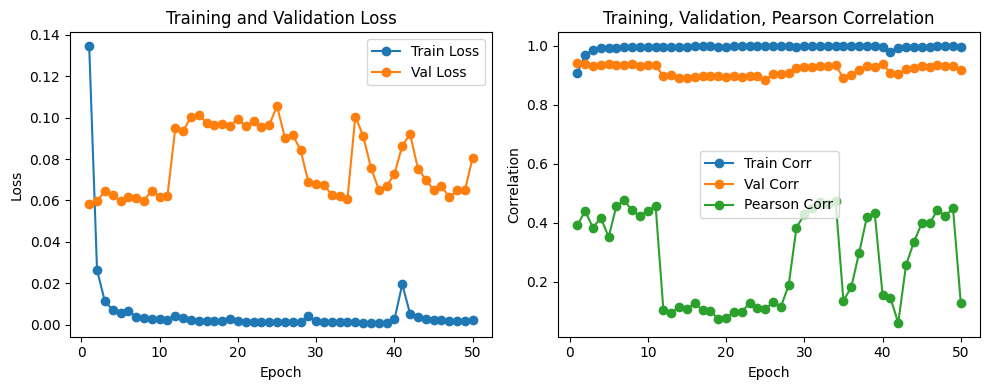

Final Pearson score: 0.1414

Testing hyperparams: {'lr': 0.01, 'alpha': 0.7, 'weight_decay': 0.001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.1562, Train Corr: 0.9072
Epoch 1/50 - Val Loss: 0.0503, Val Corr: 0.9486, Pearson Corr: 0.5291
Epoch 2/50 - Train Loss: 0.0224, Train Corr: 0.9741
Epoch 2/50 - Val Loss: 0.0530, Val Corr: 0.9459, Pearson Corr: 0.4984
Epoch 3/50 - Train Loss: 0.0123, Train Corr: 0.9855
Epoch 3/50 - Val Loss: 0.0573, Val Corr: 0.9409, Pearson Corr: 0.4692
Epoch 4/50 - Train Loss: 0.0085, Train Corr: 0.9900
Epoch 4/50 - Val Loss: 0.0574, Val Corr: 0.9402, Pearson Corr: 0.4990
Epoch 5/50 - Train Loss: 0.0068, Train Corr: 0.9921
Epoch 5/50 - Val Loss: 0.0554, Val Corr: 0.9423, Pearson Corr: 0.4995
Epoch 6/50 - Train Loss: 0.0060, Train Corr: 0.9931
Epoch 6/50 - Val Loss: 0.0588, Val Corr: 0.9384, Pearson Corr: 0.4846
Epoch 7/50 - Train Loss: 0.0045, Train Corr: 0.9950
Epoch 7/50 - Val Loss: 0.0597, Val Corr: 0.9373, Pearson Corr: 0.4913
Epoch 8/50 - Train Loss: 0.0

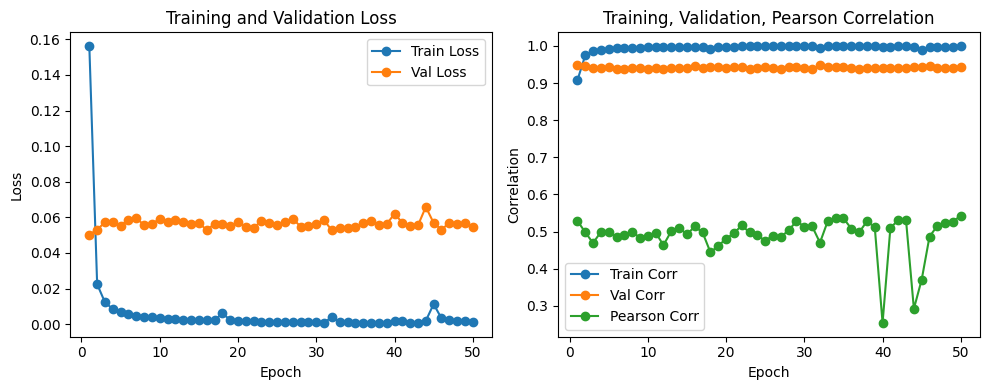

Final Pearson score: 0.5773

Testing hyperparams: {'lr': 0.005, 'alpha': 0.3, 'weight_decay': 0.0001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.0875, Train Corr: 0.8868
Epoch 1/50 - Val Loss: 0.0252, Val Corr: 0.9431, Pearson Corr: 0.2081
Epoch 2/50 - Train Loss: 0.0196, Train Corr: 0.9490
Epoch 2/50 - Val Loss: 0.0241, Val Corr: 0.9433, Pearson Corr: 0.3697
Epoch 3/50 - Train Loss: 0.0090, Train Corr: 0.9757
Epoch 3/50 - Val Loss: 0.0222, Val Corr: 0.9465, Pearson Corr: 0.5335
Epoch 4/50 - Train Loss: 0.0053, Train Corr: 0.9854
Epoch 4/50 - Val Loss: 0.0221, Val Corr: 0.9460, Pearson Corr: 0.5536
Epoch 5/50 - Train Loss: 0.0039, Train Corr: 0.9893
Epoch 5/50 - Val Loss: 0.0227, Val Corr: 0.9476, Pearson Corr: 0.4067
Epoch 6/50 - Train Loss: 0.0034, Train Corr: 0.9908
Epoch 6/50 - Val Loss: 0.0227, Val Corr: 0.9465, Pearson Corr: 0.4474
Epoch 7/50 - Train Loss: 0.0026, Train Corr: 0.9930
Epoch 7/50 - Val Loss: 0.0226, Val Corr: 0.9456, Pearson Corr: 0.4912
Epoch 8/50 - Train Loss: 0

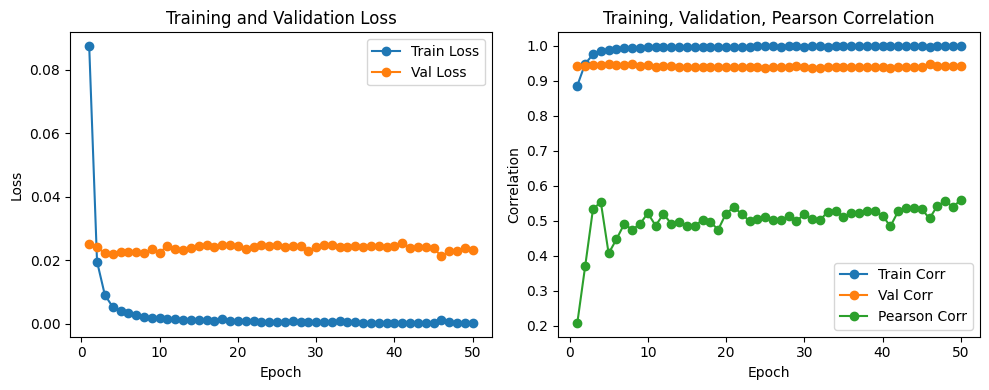

Final Pearson score: 0.5924

Testing hyperparams: {'lr': 0.005, 'alpha': 0.3, 'weight_decay': 0.001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.0963, Train Corr: 0.8786
Epoch 1/50 - Val Loss: 0.0283, Val Corr: 0.9358, Pearson Corr: 0.0835
Epoch 2/50 - Train Loss: 0.0168, Train Corr: 0.9557
Epoch 2/50 - Val Loss: 0.0240, Val Corr: 0.9431, Pearson Corr: 0.4229
Epoch 3/50 - Train Loss: 0.0076, Train Corr: 0.9792
Epoch 3/50 - Val Loss: 0.0221, Val Corr: 0.9470, Pearson Corr: 0.5419
Epoch 4/50 - Train Loss: 0.0050, Train Corr: 0.9863
Epoch 4/50 - Val Loss: 0.0225, Val Corr: 0.9469, Pearson Corr: 0.5068
Epoch 5/50 - Train Loss: 0.0038, Train Corr: 0.9896
Epoch 5/50 - Val Loss: 0.0223, Val Corr: 0.9477, Pearson Corr: 0.5089
Epoch 6/50 - Train Loss: 0.0029, Train Corr: 0.9920
Epoch 6/50 - Val Loss: 0.0223, Val Corr: 0.9476, Pearson Corr: 0.5074
Epoch 7/50 - Train Loss: 0.0025, Train Corr: 0.9932
Epoch 7/50 - Val Loss: 0.0230, Val Corr: 0.9453, Pearson Corr: 0.5113
Epoch 8/50 - Train Loss: 0.

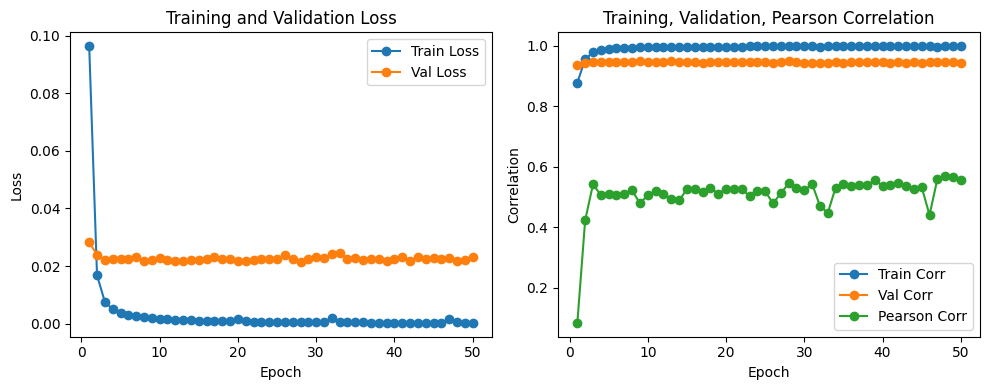

Final Pearson score: 0.5733

Testing hyperparams: {'lr': 0.005, 'alpha': 0.5, 'weight_decay': 0.0001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.1524, Train Corr: 0.8820
Epoch 1/50 - Val Loss: 0.0442, Val Corr: 0.9428, Pearson Corr: -0.0561
Epoch 2/50 - Train Loss: 0.0325, Train Corr: 0.9520
Epoch 2/50 - Val Loss: 0.0401, Val Corr: 0.9454, Pearson Corr: 0.3523
Epoch 3/50 - Train Loss: 0.0135, Train Corr: 0.9790
Epoch 3/50 - Val Loss: 0.0413, Val Corr: 0.9407, Pearson Corr: 0.4339
Epoch 4/50 - Train Loss: 0.0081, Train Corr: 0.9869
Epoch 4/50 - Val Loss: 0.0403, Val Corr: 0.9426, Pearson Corr: 0.4329
Epoch 5/50 - Train Loss: 0.0060, Train Corr: 0.9904
Epoch 5/50 - Val Loss: 0.0441, Val Corr: 0.9363, Pearson Corr: 0.3775
Epoch 6/50 - Train Loss: 0.0047, Train Corr: 0.9924
Epoch 6/50 - Val Loss: 0.0477, Val Corr: 0.9311, Pearson Corr: 0.2844
Epoch 7/50 - Train Loss: 0.0038, Train Corr: 0.9940
Epoch 7/50 - Val Loss: 0.0419, Val Corr: 0.9389, Pearson Corr: 0.4438
Epoch 8/50 - Train Loss: 

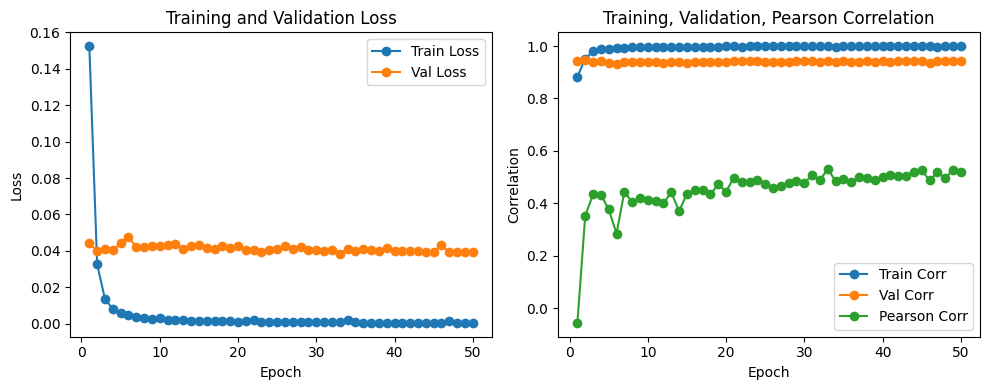

Final Pearson score: 0.5506

Testing hyperparams: {'lr': 0.005, 'alpha': 0.5, 'weight_decay': 0.001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.1838, Train Corr: 0.8710
Epoch 1/50 - Val Loss: 0.0427, Val Corr: 0.9429, Pearson Corr: 0.1667
Epoch 2/50 - Train Loss: 0.0345, Train Corr: 0.9458
Epoch 2/50 - Val Loss: 0.0384, Val Corr: 0.9453, Pearson Corr: 0.4667
Epoch 3/50 - Train Loss: 0.0161, Train Corr: 0.9742
Epoch 3/50 - Val Loss: 0.0393, Val Corr: 0.9432, Pearson Corr: 0.4481
Epoch 4/50 - Train Loss: 0.0098, Train Corr: 0.9838
Epoch 4/50 - Val Loss: 0.0380, Val Corr: 0.9450, Pearson Corr: 0.4839
Epoch 5/50 - Train Loss: 0.0072, Train Corr: 0.9882
Epoch 5/50 - Val Loss: 0.0388, Val Corr: 0.9437, Pearson Corr: 0.4978
Epoch 6/50 - Train Loss: 0.0058, Train Corr: 0.9906
Epoch 6/50 - Val Loss: 0.0388, Val Corr: 0.9434, Pearson Corr: 0.5053
Epoch 7/50 - Train Loss: 0.0049, Train Corr: 0.9921
Epoch 7/50 - Val Loss: 0.0378, Val Corr: 0.9449, Pearson Corr: 0.5332
Epoch 8/50 - Train Loss: 0.

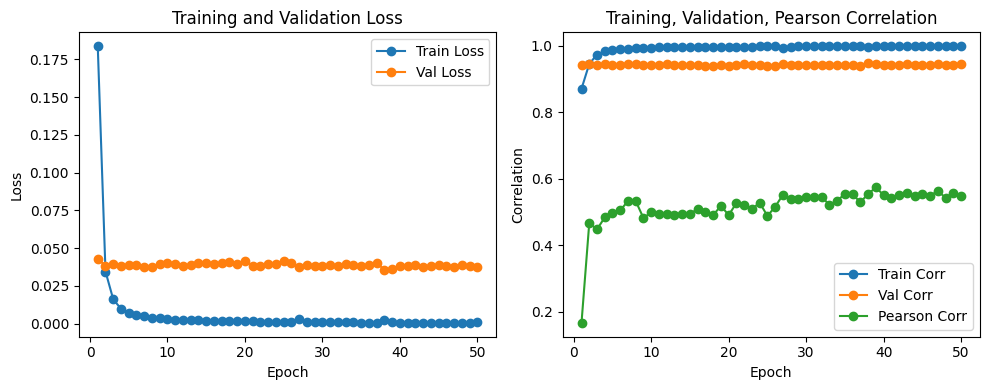

Final Pearson score: 0.5754

Testing hyperparams: {'lr': 0.005, 'alpha': 0.7, 'weight_decay': 0.0001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.2853, Train Corr: 0.8627
Epoch 1/50 - Val Loss: 0.0609, Val Corr: 0.9417, Pearson Corr: 0.1322
Epoch 2/50 - Train Loss: 0.0524, Train Corr: 0.9415
Epoch 2/50 - Val Loss: 0.0540, Val Corr: 0.9466, Pearson Corr: 0.3520
Epoch 3/50 - Train Loss: 0.0261, Train Corr: 0.9704
Epoch 3/50 - Val Loss: 0.0567, Val Corr: 0.9442, Pearson Corr: 0.2665
Epoch 4/50 - Train Loss: 0.0163, Train Corr: 0.9810
Epoch 4/50 - Val Loss: 0.0488, Val Corr: 0.9499, Pearson Corr: 0.5454
Epoch 5/50 - Train Loss: 0.0112, Train Corr: 0.9869
Epoch 5/50 - Val Loss: 0.0517, Val Corr: 0.9474, Pearson Corr: 0.4870
Epoch 6/50 - Train Loss: 0.0089, Train Corr: 0.9896
Epoch 6/50 - Val Loss: 0.0502, Val Corr: 0.9479, Pearson Corr: 0.5474
Epoch 7/50 - Train Loss: 0.0077, Train Corr: 0.9910
Epoch 7/50 - Val Loss: 0.0526, Val Corr: 0.9482, Pearson Corr: 0.4072
Epoch 8/50 - Train Loss: 0

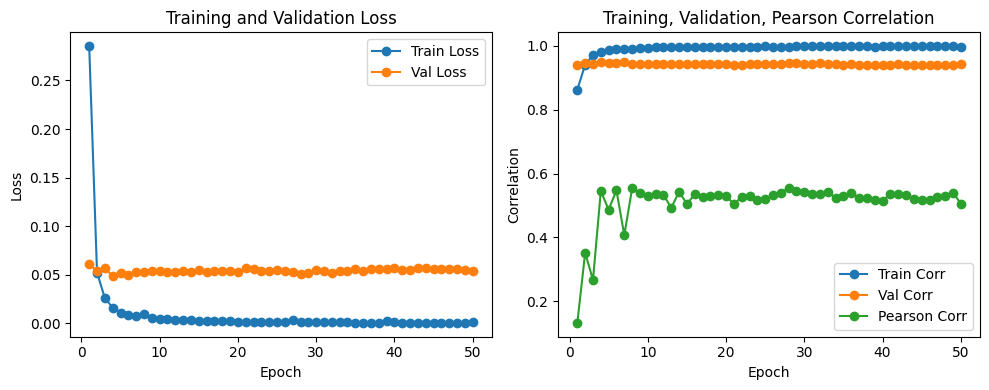

Final Pearson score: 0.5445

Testing hyperparams: {'lr': 0.005, 'alpha': 0.7, 'weight_decay': 0.001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.1946, Train Corr: 0.8894
Epoch 1/50 - Val Loss: 0.0616, Val Corr: 0.9425, Pearson Corr: 0.2579
Epoch 2/50 - Train Loss: 0.0386, Train Corr: 0.9565
Epoch 2/50 - Val Loss: 0.0537, Val Corr: 0.9465, Pearson Corr: 0.4029
Epoch 3/50 - Train Loss: 0.0173, Train Corr: 0.9798
Epoch 3/50 - Val Loss: 0.0484, Val Corr: 0.9503, Pearson Corr: 0.5587
Epoch 4/50 - Train Loss: 0.0107, Train Corr: 0.9875
Epoch 4/50 - Val Loss: 0.0496, Val Corr: 0.9483, Pearson Corr: 0.5705
Epoch 5/50 - Train Loss: 0.0079, Train Corr: 0.9908
Epoch 5/50 - Val Loss: 0.0524, Val Corr: 0.9452, Pearson Corr: 0.5453
Epoch 6/50 - Train Loss: 0.0063, Train Corr: 0.9927
Epoch 6/50 - Val Loss: 0.0519, Val Corr: 0.9458, Pearson Corr: 0.5294
Epoch 7/50 - Train Loss: 0.0053, Train Corr: 0.9940
Epoch 7/50 - Val Loss: 0.0519, Val Corr: 0.9463, Pearson Corr: 0.5247
Epoch 8/50 - Train Loss: 0.

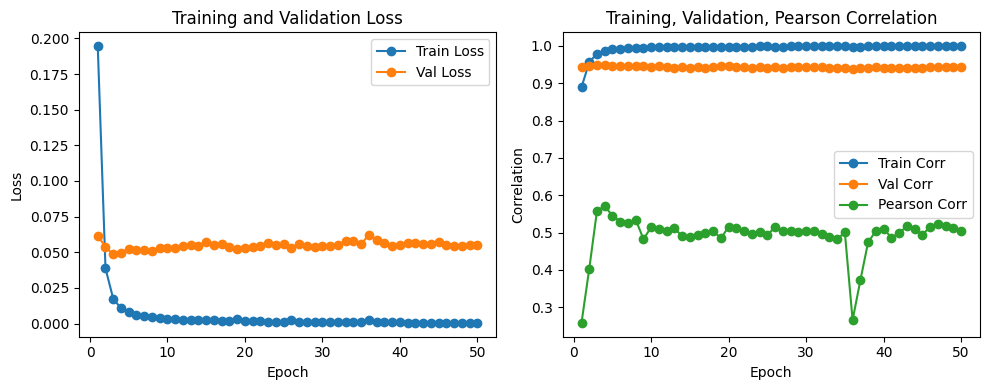

Final Pearson score: 0.5319

Testing hyperparams: {'lr': 0.001, 'alpha': 0.3, 'weight_decay': 0.0001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.2279, Train Corr: 0.7912
Epoch 1/50 - Val Loss: 0.0269, Val Corr: 0.9403, Pearson Corr: -0.0842
Epoch 2/50 - Train Loss: 0.0503, Train Corr: 0.8936
Epoch 2/50 - Val Loss: 0.0259, Val Corr: 0.9419, Pearson Corr: -0.0327
Epoch 3/50 - Train Loss: 0.0356, Train Corr: 0.9144
Epoch 3/50 - Val Loss: 0.0252, Val Corr: 0.9437, Pearson Corr: 0.0455
Epoch 4/50 - Train Loss: 0.0282, Train Corr: 0.9299
Epoch 4/50 - Val Loss: 0.0245, Val Corr: 0.9447, Pearson Corr: 0.1862
Epoch 5/50 - Train Loss: 0.0216, Train Corr: 0.9454
Epoch 5/50 - Val Loss: 0.0222, Val Corr: 0.9479, Pearson Corr: 0.4488
Epoch 6/50 - Train Loss: 0.0168, Train Corr: 0.9572
Epoch 6/50 - Val Loss: 0.0234, Val Corr: 0.9449, Pearson Corr: 0.4022
Epoch 7/50 - Train Loss: 0.0126, Train Corr: 0.9676
Epoch 7/50 - Val Loss: 0.0228, Val Corr: 0.9458, Pearson Corr: 0.4720
Epoch 8/50 - Train Loss:

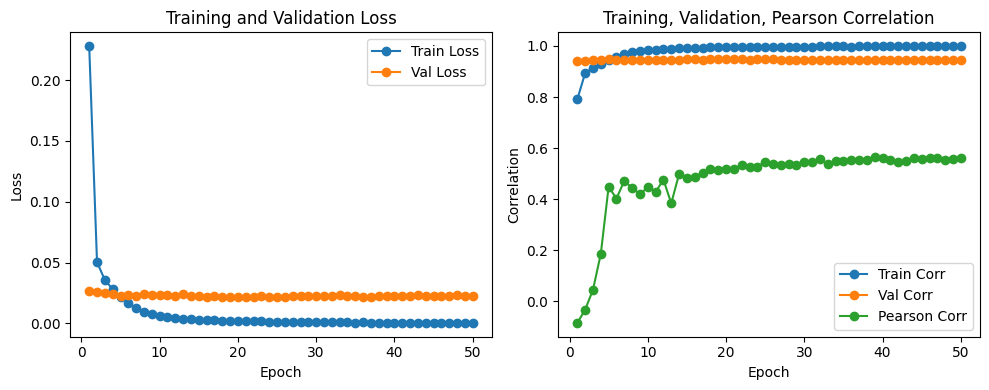

Final Pearson score: 0.5851

Testing hyperparams: {'lr': 0.001, 'alpha': 0.3, 'weight_decay': 0.001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.2704, Train Corr: 0.7865
Epoch 1/50 - Val Loss: 0.0425, Val Corr: 0.8914, Pearson Corr: -0.0350
Epoch 2/50 - Train Loss: 0.0491, Train Corr: 0.8897
Epoch 2/50 - Val Loss: 0.0274, Val Corr: 0.9385, Pearson Corr: -0.0533
Epoch 3/50 - Train Loss: 0.0372, Train Corr: 0.9082
Epoch 3/50 - Val Loss: 0.0287, Val Corr: 0.9351, Pearson Corr: -0.0354
Epoch 4/50 - Train Loss: 0.0311, Train Corr: 0.9207
Epoch 4/50 - Val Loss: 0.0263, Val Corr: 0.9415, Pearson Corr: -0.0410
Epoch 5/50 - Train Loss: 0.0268, Train Corr: 0.9312
Epoch 5/50 - Val Loss: 0.0249, Val Corr: 0.9445, Pearson Corr: 0.0714
Epoch 6/50 - Train Loss: 0.0223, Train Corr: 0.9428
Epoch 6/50 - Val Loss: 0.0235, Val Corr: 0.9473, Pearson Corr: 0.2042
Epoch 7/50 - Train Loss: 0.0177, Train Corr: 0.9544
Epoch 7/50 - Val Loss: 0.0229, Val Corr: 0.9478, Pearson Corr: 0.2980
Epoch 8/50 - Train Loss

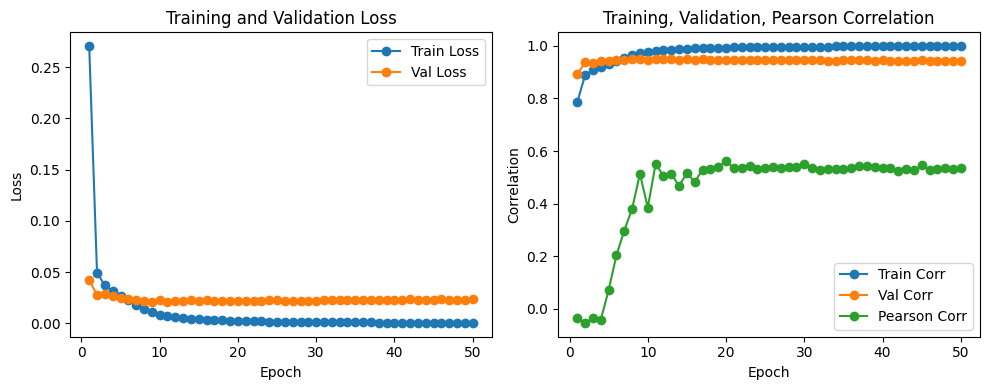

Final Pearson score: 0.5668

Testing hyperparams: {'lr': 0.001, 'alpha': 0.5, 'weight_decay': 0.0001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.4875, Train Corr: 0.7485
Epoch 1/50 - Val Loss: 0.0483, Val Corr: 0.9403, Pearson Corr: -0.1132
Epoch 2/50 - Train Loss: 0.0931, Train Corr: 0.8817
Epoch 2/50 - Val Loss: 0.0462, Val Corr: 0.9414, Pearson Corr: -0.0574
Epoch 3/50 - Train Loss: 0.0650, Train Corr: 0.9060
Epoch 3/50 - Val Loss: 0.0438, Val Corr: 0.9420, Pearson Corr: -0.0499
Epoch 4/50 - Train Loss: 0.0553, Train Corr: 0.9182
Epoch 4/50 - Val Loss: 0.0426, Val Corr: 0.9422, Pearson Corr: 0.0611
Epoch 5/50 - Train Loss: 0.0461, Train Corr: 0.9304
Epoch 5/50 - Val Loss: 0.0412, Val Corr: 0.9427, Pearson Corr: 0.2910
Epoch 6/50 - Train Loss: 0.0372, Train Corr: 0.9434
Epoch 6/50 - Val Loss: 0.0406, Val Corr: 0.9446, Pearson Corr: 0.2414
Epoch 7/50 - Train Loss: 0.0281, Train Corr: 0.9569
Epoch 7/50 - Val Loss: 0.0420, Val Corr: 0.9431, Pearson Corr: 0.2049
Epoch 8/50 - Train Loss

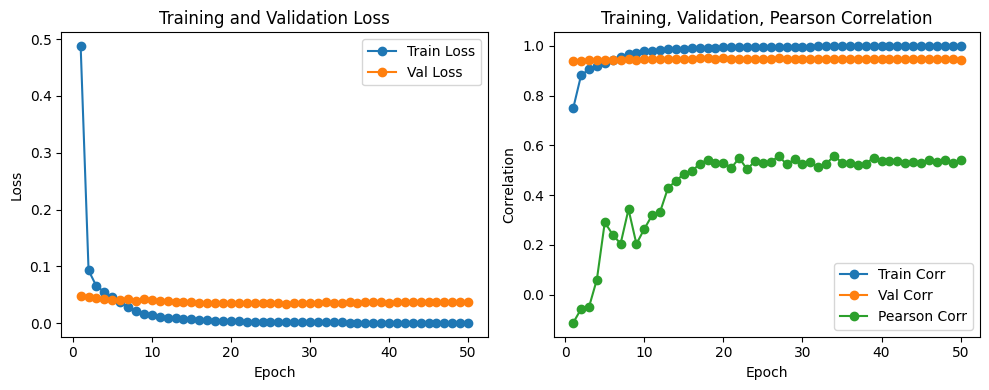

Final Pearson score: 0.5681

Testing hyperparams: {'lr': 0.001, 'alpha': 0.5, 'weight_decay': 0.001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.6363, Train Corr: 0.7326
Epoch 1/50 - Val Loss: 0.0467, Val Corr: 0.9398, Pearson Corr: -0.1467
Epoch 2/50 - Train Loss: 0.1186, Train Corr: 0.8806
Epoch 2/50 - Val Loss: 0.0436, Val Corr: 0.9412, Pearson Corr: 0.1050
Epoch 3/50 - Train Loss: 0.0775, Train Corr: 0.9036
Epoch 3/50 - Val Loss: 0.0422, Val Corr: 0.9427, Pearson Corr: 0.1404
Epoch 4/50 - Train Loss: 0.0590, Train Corr: 0.9200
Epoch 4/50 - Val Loss: 0.0412, Val Corr: 0.9438, Pearson Corr: 0.2249
Epoch 5/50 - Train Loss: 0.0473, Train Corr: 0.9334
Epoch 5/50 - Val Loss: 0.0409, Val Corr: 0.9439, Pearson Corr: 0.2618
Epoch 6/50 - Train Loss: 0.0371, Train Corr: 0.9461
Epoch 6/50 - Val Loss: 0.0376, Val Corr: 0.9475, Pearson Corr: 0.4230
Epoch 7/50 - Train Loss: 0.0283, Train Corr: 0.9579
Epoch 7/50 - Val Loss: 0.0417, Val Corr: 0.9425, Pearson Corr: 0.2872
Epoch 8/50 - Train Loss: 0

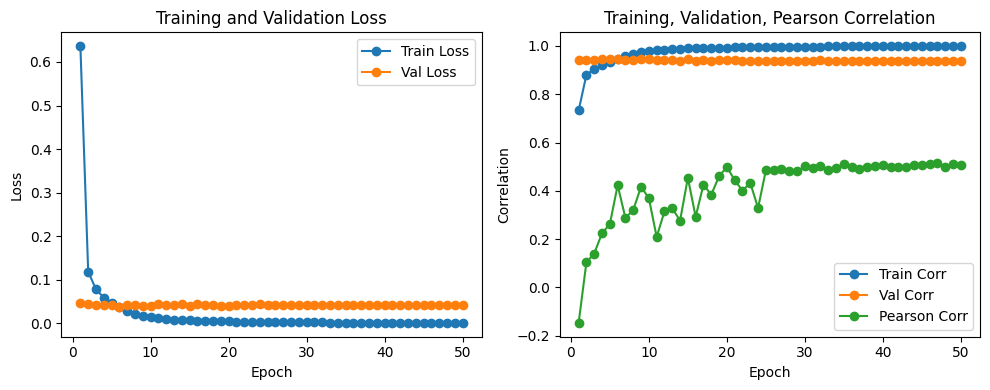

Final Pearson score: 0.5511

Testing hyperparams: {'lr': 0.001, 'alpha': 0.7, 'weight_decay': 0.0001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.7237, Train Corr: 0.7326
Epoch 1/50 - Val Loss: 0.0643, Val Corr: 0.9405, Pearson Corr: 0.0850
Epoch 2/50 - Train Loss: 0.1318, Train Corr: 0.8810
Epoch 2/50 - Val Loss: 0.0626, Val Corr: 0.9416, Pearson Corr: 0.0738
Epoch 3/50 - Train Loss: 0.0943, Train Corr: 0.9047
Epoch 3/50 - Val Loss: 0.0609, Val Corr: 0.9426, Pearson Corr: 0.1093
Epoch 4/50 - Train Loss: 0.0769, Train Corr: 0.9193
Epoch 4/50 - Val Loss: 0.0582, Val Corr: 0.9439, Pearson Corr: 0.1597
Epoch 5/50 - Train Loss: 0.0645, Train Corr: 0.9317
Epoch 5/50 - Val Loss: 0.0573, Val Corr: 0.9443, Pearson Corr: 0.2514
Epoch 6/50 - Train Loss: 0.0534, Train Corr: 0.9426
Epoch 6/50 - Val Loss: 0.0535, Val Corr: 0.9466, Pearson Corr: 0.4097
Epoch 7/50 - Train Loss: 0.0420, Train Corr: 0.9543
Epoch 7/50 - Val Loss: 0.0530, Val Corr: 0.9460, Pearson Corr: 0.4581
Epoch 8/50 - Train Loss: 0

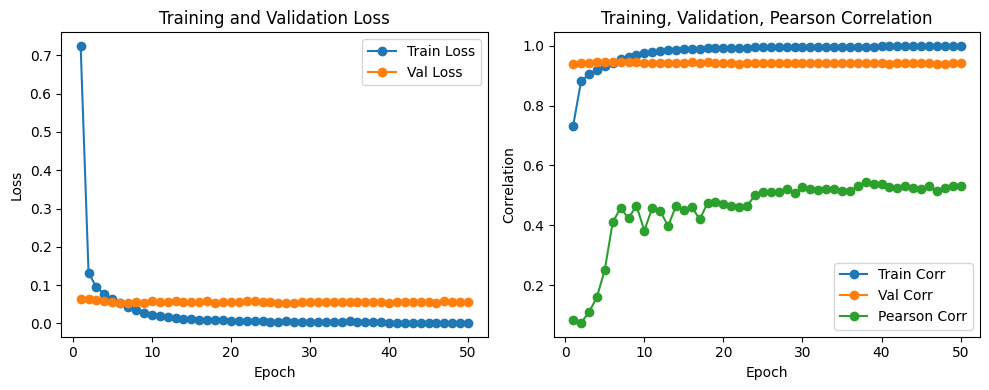

Final Pearson score: 0.5610

Testing hyperparams: {'lr': 0.001, 'alpha': 0.7, 'weight_decay': 0.001, 'num_epochs': 50}
Epoch 1/50 - Train Loss: 0.8280, Train Corr: 0.7604
Epoch 1/50 - Val Loss: 0.0643, Val Corr: 0.9392, Pearson Corr: -0.0067
Epoch 2/50 - Train Loss: 0.1575, Train Corr: 0.8851
Epoch 2/50 - Val Loss: 0.0616, Val Corr: 0.9412, Pearson Corr: -0.0309
Epoch 3/50 - Train Loss: 0.1071, Train Corr: 0.9050
Epoch 3/50 - Val Loss: 0.0623, Val Corr: 0.9409, Pearson Corr: -0.0601
Epoch 4/50 - Train Loss: 0.0799, Train Corr: 0.9230
Epoch 4/50 - Val Loss: 0.0625, Val Corr: 0.9403, Pearson Corr: 0.0124
Epoch 5/50 - Train Loss: 0.0635, Train Corr: 0.9356
Epoch 5/50 - Val Loss: 0.0677, Val Corr: 0.9361, Pearson Corr: -0.0665
Epoch 6/50 - Train Loss: 0.0502, Train Corr: 0.9475
Epoch 6/50 - Val Loss: 0.0654, Val Corr: 0.9397, Pearson Corr: -0.0368
Epoch 7/50 - Train Loss: 0.0376, Train Corr: 0.9598
Epoch 7/50 - Val Loss: 0.0780, Val Corr: 0.9236, Pearson Corr: -0.0280
Epoch 8/50 - Train Lo

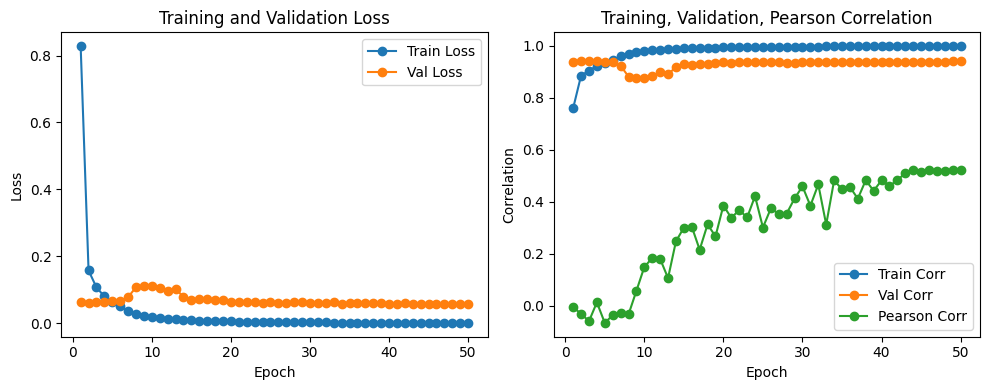

Final Pearson score: 0.5484

Best hyperparameters: {'lr': 0.005, 'alpha': 0.3, 'weight_decay': 0.0001, 'num_epochs': 50}
Best Pearson score: 0.5924


In [14]:
param_grid = {
    'lr': [1e-2, 5e-3, 1e-3],
    'alpha': [0.3, 0.5, 0.7],
    'weight_decay': [1e-4, 1e-3],
    'num_epochs': [50]
}

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

best_score = -float('inf')
best_params = None
best_model = None

for combo in param_combinations:
    params = dict(zip(param_names, combo))
    print(f"\nTesting hyperparams: {params}")

    model = EncoderDecoder(input_channels=CHANNELS_NUM * WAVELET_NUM, output_channels=5)

    trained_model = train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=params['num_epochs'],
        lr=params['lr'],
        alpha=params['alpha'],
        weight_decay=params['weight_decay'],
    )

    # Evaluate final Pearson correlation from the model
    actuals, predictions = test_model(model, val_loader, device=DEVICE)
    final_pearson = pearson_correlation_metric(torch.tensor(predictions), torch.tensor(actuals)).item()
    print(f"Final Pearson score: {final_pearson:.4f}")

    if final_pearson > best_score:
        best_score = final_pearson
        best_params = params
        best_model = trained_model

print(f"\nBest hyperparameters: {best_params}")
print(f"Best Pearson score: {best_score:.4f}")

### 2.2 Best Model

In [24]:
actuals, predictions = test_model(best_model, val_loader, device=DEVICE)
print(actuals.shape, predictions.shape)

(19724, 5, 256) (19724, 5, 256)


In [ ]:
# Print pearon correlation (SotA model 0.67)
final_pearson = pearson_correlation_metric(torch.tensor(predictions), torch.tensor(actuals)).item()
print("Final Pearson Correlation: ", final_pearson)
torch.save(best_model.state_dict(), f"../{SUBJECT_ID}.pth")

Final Pearson Correlation:  0.5924338698387146
